In [2]:
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\xarray_schema\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\anndata\utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWar

In [3]:
adata = sc.read_h5ad('adata.h5ad')
print(adata)

C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1348582 × 990
    obs: 'x', 'y', 'Mouse_ID', 'Technical_repeat_number', 'Sample_type', 'Slice_ID', 'FOV', 'Cell_ID', 'sample', 'N_genes', 'Tier1', 'Tier2', 'Tier3', 'Leiden_neigh', 'Neigh_umap_x', 'Neigh_umap_y', 'Tier2_umap_x', 'Tier2_umap_y', 'Tier3_umap_x', 'Tier3_umap_y', 'Tier1_umap_x', 'Tier1_umap_y'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Neigh_anndata', 'Sample_type_colors', 'Tier1_colors', 'Tier2_colors', 'Tier3_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [3]:
combined = sc.read_h5ad('combined_mouse_colon.h5ad')
print(combined)

AnnData object with n_obs × n_vars = 7181 × 16693
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'doublet_class', 'Epithelial_sum_expr', 'PanImmune_sum_expr', 'PlasmaCell_sum_expr', 'NKCell_sum_expr', 'Myeloid_sum_expr', 'Monocyte_Mac_sum_expr', 'Dendritic_sum_expr', 'MastCell_sum_expr', 'Endothelial_sum_expr', 'Lymphatic_Endo_sum_expr', 'Glial_sum_expr', 'Pericyte_sum_expr', 'SMC_sum_expr', 'Fibroblast_sum_expr', 'cell_type', 'condition', 'mouse', 'Epithelial_marker_sum', 'PanImmune_marker_sum', 'PlasmaCell_marker_sum', 'NKCell_marker_sum', 'Myeloid_marker_sum', 'Monocyte_Mac_marker_sum', 'Dendritic_marker_sum', 'MastCell_marker_sum', 'Endothelial_marker_sum', 'Lymphatic_Endo_marker_sum', 'Glial_marker_sum', 'Pericyte_marker_sum', 'SMC_marker_sum', 'Fibroblast_marker_sum', 'predicted.id', 'prediction.score.SMC', 'prediction.score.Lymphatic.endothelial', 'prediction.score.Fibroblasts', 'prediction.score.Vascular.endothelial', 'p

In [6]:
genes_adata = list(adata.var_names)
genes_combined = set(combined.var_names)

In [11]:
df_genes = pd.DataFrame({
    "gene": genes_adata,
    "in_combined": [g in genes_combined for g in genes_adata]
})
print(df_genes.head())

    gene  in_combined
0  Ackr1         True
1  Ackr2         True
2  Ackr3         True
3  Ackr4         True
4  Acod1        False


In [13]:
print(sum(df_genes['in_combined']))
df_genes.to_csv("adata_genes.csv", index=False)

760


In [14]:
celltype_markers = {
  "Epithelial":       ["Cdh1","Epcam","Alpi","Muc2","Vil1","Lyz1","Lgr5","Olfm4","Ccnd1"],
  "PanImmune":        ["Ptprc"],
  "BCell":            ["Ms4a1","Cd19"],
  "PlasmaCell":       ["Mzb1","Ccr10","Sdc1"],
  "TCell":            ["Cd3e"],
  "CD4_TCell":        ["Cd4"],
  "CD8_TCell":        ["Cd8a","Cd8b"],
  "NKCell":           ["Nkg7","Ncam1"],
  "Myeloid":          ["Cd68","Cd74"],
  "Monocyte_Mac":     ["Cd14"],
  "Dendritic":        ["Itgax"],
  "MastCell":         ["Kit","Il1rl1"],
  "Treg":             ["Foxp3"],
  "Endothelial":      ["Pecam1"],
  "Lymphatic_Endo":   ["Lyve1"],
  "Glial":            ["Plp1","S100b"],
  "Pericyte":         ["Rgs5","Pdgfrb","Adipoq"],
  "SMC":              ["Myh11","Actg2","Myocd","Des","Acta2"],
  "Fibroblast":       ["Pdgfra","Sparc","Dcn","Lum","Col1a1","Col14a1","Fgfr2",
                       "Col3a1","Col4a5","Col4a6","Bmp5","Bmp4","Grem1","Vcam1",
                       "Ogn","Mgp","Sfrp2","C3","Dpt"]
}

In [17]:
observed = set(adata.var_names)

# Prepare report of missing markers
rows = []
for celltype, markers in celltype_markers.items():
    missing = [g for g in markers if g not in observed]
    rows.append({
        "celltype": celltype,
        "missing_genes": ",".join(missing) if missing else ""
    })

df_missing = pd.DataFrame(rows)
print(df_missing)

# Save to CSV
df_missing.to_csv("missing_markers.csv", index=False)

          celltype                          missing_genes
0       Epithelial  Cdh1,Epcam,Alpi,Muc2,Lyz1,Olfm4,Ccnd1
1        PanImmune                                       
2            BCell                                       
3       PlasmaCell                                   Mzb1
4            TCell                                       
5        CD4_TCell                                       
6        CD8_TCell                                   Cd8b
7           NKCell                                   Nkg7
8          Myeloid                                   Cd74
9     Monocyte_Mac                                       
10       Dendritic                                       
11        MastCell                                       
12            Treg                                       
13     Endothelial                                       
14  Lymphatic_Endo                                       
15           Glial                             Plp1,S100b
16        Peri

# Neighborhood Plots - Sample

In [32]:
adata_d0 = adata[adata.obs['Sample_type'] == 'Healthy'].copy()
adata_d9 = adata[adata.obs['Sample_type'] == 'DSS9'].copy() 

#Pick one Slice_ID from each
slice0 = adata_d0.obs['Slice_ID'].unique()[0]
slice9 = adata_d9.obs['Slice_ID'].unique()[0]

#Further subset to these slices
adata_d0_slice = adata_d0[adata_d0.obs['Slice_ID'] == slice0].copy()
adata_d9_slice = adata_d9[adata_d9.obs['Slice_ID'] == slice9].copy()

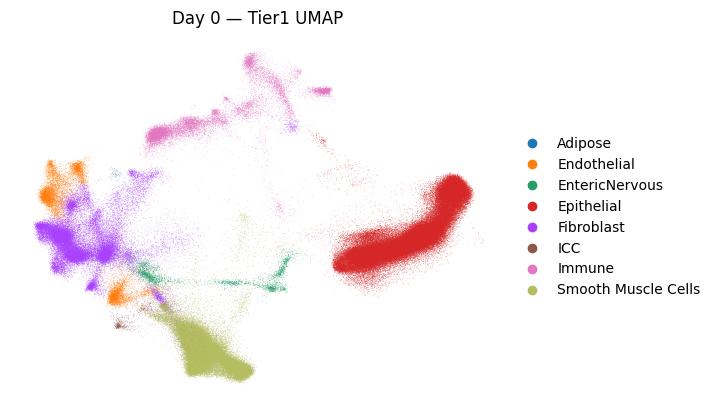

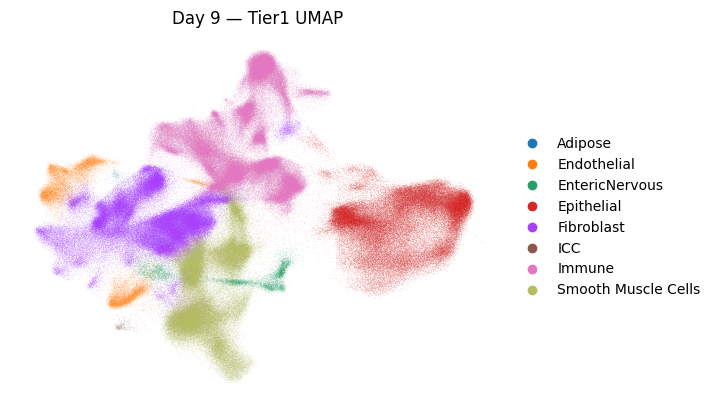

In [35]:
# Plot UMAP embedding colored by Tier1 cell types
sc.pl.umap(
    adata_d0,
    color='Tier1',
    title=f"Day 0 — Tier1 UMAP",
    frameon=False
)
sc.pl.umap(
    adata_d9,
    color='Tier1',
    title=f"Day 9 — Tier1 UMAP",
    frameon=False
)


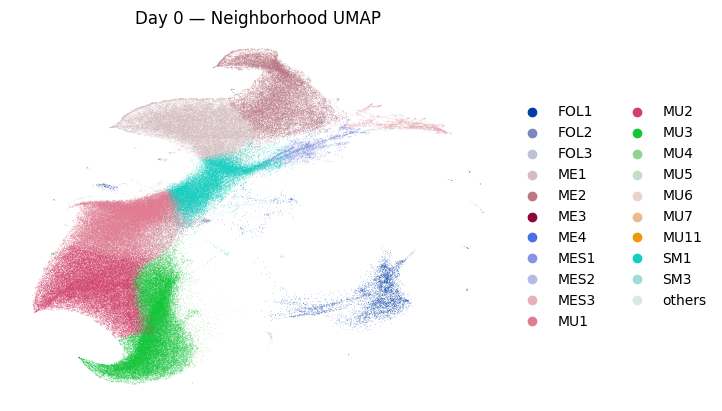

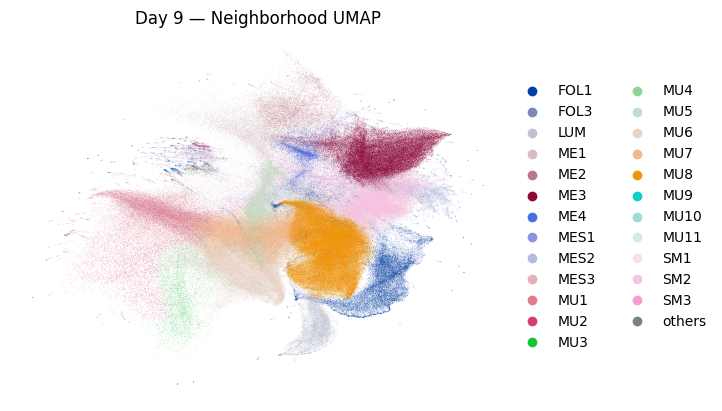

In [37]:
# Plot the precomputed neighborhood UMAP
adata_d0.obsm['neigh_umap'] = adata_d0.obs[['Neigh_umap_x','Neigh_umap_y']].values
adata_d9.obsm['neigh_umap'] = adata_d9.obs[['Neigh_umap_x','Neigh_umap_y']].values

sc.pl.embedding(
    adata_d0,
    basis="neigh_umap", 
    color="Leiden_neigh",
    title="Day 0 — Neighborhood UMAP",
    frameon=False
)

sc.pl.embedding(
    adata_d9,
    basis="neigh_umap", 
    color="Leiden_neigh",
    title="Day 9 — Neighborhood UMAP",
    frameon=False
)

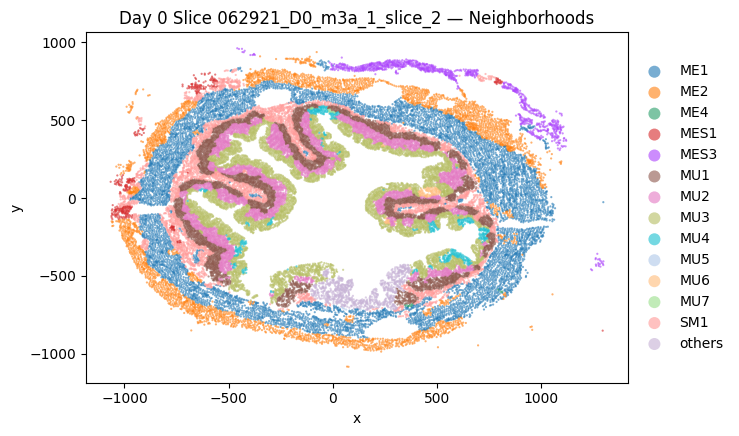

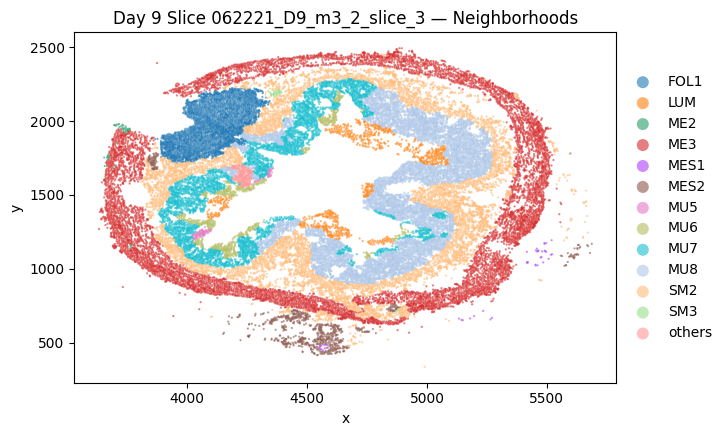

In [41]:
sc.pl.scatter(
    adata_d0_slice,
    x='x', y='y',
    color='Leiden_neigh',
    size=10,
    alpha=0.6,
    title=f"Day 0 Slice {slice0} — Neighborhoods"
)

# Day 9
sc.pl.scatter(
    adata_d9_slice,
    x='x', y='y',
    color='Leiden_neigh',
    size=10,
    alpha=0.6,
    title=f"Day 9 Slice {slice9} — Neighborhoods"
)

In [54]:
fibro_cells = adata_d0_slice.obs_names[adata_d0_slice.obs['Tier1'] == 'Fibroblast']

# Randomly choose one fibroblast
target_cell = np.random.choice(fibro_cells, size=1)[0]
print(f"Chosen cell: {target_cell}")

Chosen cell: 44986


In [55]:

# Look up its integer index and pull neighbors from the connectivity graph
cell_idx    = adata_d0_slice.obs_names.get_loc(target_cell)
conn_matrix = adata_d0_slice.obsp['connectivities']    # should be a sparse matrix
nbr_idx     = conn_matrix[cell_idx].nonzero()[1]  # neighbor indices

# Build a subset AnnData with the query + its neighbors
all_idx     = np.concatenate([[cell_idx], nbr_idx])
subset_bcs  = adata_d0_slice.obs_names[all_idx]
adata_neigh = adata_d0_slice[subset_bcs].copy()

In [1]:
# Plot on spatial coords
plt.figure(figsize=(4,4), dpi=150)

# plot neighbors in light gray
mask_neighbors = adata_neigh.obs_names != target_cell
sc.pl.scatter(
    adata_neigh[mask_neighbors],
    x='x', y='y',
    color='Leiden_neigh',
    size=50,
    alpha=0.8,
    show=False
)

# overplot the target cell in red star
tc = adata_neigh[target_cell]
plt.scatter(
    tc.obs['x'], tc.obs['y'],
    s=200,
    marker='*',
    c='red',
    edgecolor='black',
    linewidth=1.5,
    label='Target cell'
)

# match your other plots’ style
plt.gca().invert_yaxis()
plt.axis('off')
plt.legend(frameon=False, loc='upper right')
plt.title(f"Spatial neighborhood of fibroblast {target_cell}")
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined